# Determining whether we can spy on leaky video signals with Deep Neural Networks


In this notebook, we'll try and see if we can determine what is shown on the monitor screen based only on the leaked EM radiation as captured by an rtl-sdr device. 

Theoretically, the leaked signals contain all the data we need to determine whats displayed. Its possible the resolution of signals is not high enough to capture every pixel worth of data and we need a better rtl-sdr device. To start off, we'll attempt to display 4 different images on the screen, collect the leaky signals and then attempt to predict the image based solely on the signals. 

The 4 different screens captured for this exercise.

<img src='sdr_screen_capture.png' width=70% />

### Data Collection

The rtl-sdr dongle used is an el-cheapo NooElec purchased for around $20. A wide band survey was done with the antenna placed in the vacinity of the monitor with the monitor playing a youtube video and then another survey with the monitor turned off and same video playing. Each survey was done over a 10 minute period. This enabled us to determine the exact band where there was activity with the monitor turned on.

The data samples were collected by surveys over the identified band each second for a total of 5 minute period. This was repeated for each image displayed on the monitor

### Methodology

Since we did not collect a lot of data, we'll use a smaller subset for validation and about 10% for the testing performance

In [1]:
import math
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Reshape, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras import optimizers
import numpy as np
import scipy.io.wavfile
import os
from os.path import normpath, basename
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.image as mpimg
from IPython.display import display, Markdown, Latex
import pandas as pd

In [2]:
from glob import glob

def load_data(dimens = 39, directory = 'data/'):
    out_x = np.zeros((0, dimens))
    out_y = np.zeros(0)
    y_dict = {}
    
    path, dirs, files = next(os.walk(directory))
    file_count = len(files)
    
    for i, file in zip(range(0, file_count), glob('data/*.csv')):
        df = pd.read_csv(file, header=None)
        out_x = np.concatenate((out_x, df.values), axis = 0)
        out_y = np.concatenate((out_y, np.full((df.values.shape[0]), i)))
        y_dict[file] = i
        
    return (out_x, out_y, y_dict)
        

In [39]:
display(Markdown('#### Load the data'))

data_x, data_y, y_dict = load_data()
print(data_x.shape)
print(data_y.shape)
print(y_dict)

#### Load the data

(4800, 39)
(4800,)
{'data/bottom_left_white.csv': 0, 'data/bottom_right_white.csv': 1, 'data/top_left_white.csv': 2, 'data/top_right_white.csv': 3}


In [4]:
display(Markdown('#### The cleanup consists of removing non relevant columns and taking mean across full frequency range'))

print(data_x[0])
display(Markdown('#### The first few columns do not contain relevant data so snip snip ...'))

data_x = data_x[:, 6:]
print(data_x[0])




#### The cleanup consists of removing non relevant columns and taking mean across full frequency range

['2019-04-03' ' 20:47:09' 960000000 962500000 78125.0 1024 -8.97 -12.31
 -14.78 -15.45 -14.63 -14.03 -14.16 -14.4 -14.18 -14.29 -14.6 -14.11 -14.3
 -14.25 -14.49 -13.29 -14.22 -14.22 -15.07 -14.92 -14.82 -14.81 -14.8
 -14.71 -14.55 -14.31 -13.75 -14.18 -14.71 -16.31 -17.28 -15.0 -15.0]


#### The first few columns do not contain relevant data so snip snip ...

[-8.97 -12.31 -14.78 -15.45 -14.63 -14.03 -14.16 -14.4 -14.18 -14.29 -14.6
 -14.11 -14.3 -14.25 -14.49 -13.29 -14.22 -14.22 -15.07 -14.92 -14.82
 -14.81 -14.8 -14.71 -14.55 -14.31 -13.75 -14.18 -14.71 -16.31 -17.28
 -15.0 -15.0]


In [5]:
print(data_x[0])

print(data_x.shape)
display(Markdown('#### Merge each 4 consecutive rows since they are different frequency range over same time interval'))
print((data_x.reshape(-1, 4, data_x.shape[1])[0]))

data_x_by_second = data_x.reshape(-1, 4, data_x.shape[1])
print(data_x_by_second.shape)
data_y_by_second = data_y.reshape(-1, 4)
print(data_y_by_second.shape)

data_x_clean = np.zeros((0, data_x.shape[1]))
data_y_clean = []
for second, y in zip(data_x_by_second, data_y_by_second):
    second_mean = np.mean(second, axis=0)
    data_x_clean = np.concatenate((data_x_clean, second_mean.reshape(-1, data_x.shape[1])), axis=0)
    data_y_clean.append(y[0])
    
print(data_x_clean.shape)
data_y_clean = np.array(data_y_clean)
print(data_y_clean.shape)


[-8.97 -12.31 -14.78 -15.45 -14.63 -14.03 -14.16 -14.4 -14.18 -14.29 -14.6
 -14.11 -14.3 -14.25 -14.49 -13.29 -14.22 -14.22 -15.07 -14.92 -14.82
 -14.81 -14.8 -14.71 -14.55 -14.31 -13.75 -14.18 -14.71 -16.31 -17.28
 -15.0 -15.0]
(4800, 33)


#### Merge each 4 consecutive rows since they are different frequency range over same time interval

[[-8.97 -12.31 -14.78 -15.45 -14.63 -14.03 -14.16 -14.4 -14.18 -14.29
  -14.6 -14.11 -14.3 -14.25 -14.49 -13.29 -14.22 -14.22 -15.07 -14.92
  -14.82 -14.81 -14.8 -14.71 -14.55 -14.31 -13.75 -14.18 -14.71 -16.31
  -17.28 -15.0 -15.0]
 [-16.81 -17.49 -16.7 -15.84 -15.29 -14.55 -14.13 -14.02 -13.83 -14.29
  -13.97 -13.35 -12.62 -11.7 -11.54 -11.49 -12.43 -12.43 -12.26 -12.55
  -12.62 -13.39 -13.77 -14.56 -14.71 -14.51 -14.46 -14.53 -13.37 -13.25
  -13.27 -15.3 -15.3]
 [-12.95 -12.5 -10.14 -7.63 -6.76 -2.38 -3.88 -0.26 -3.01 0.02 -0.67 0.97
  7.47 8.14 4.11 -1.43 -3.69 -3.69 -5.57 -6.44 -4.2 -7.02 -4.08 -7.5 -5.6
  -8.12 -8.57 -5.93 -7.68 -9.56 -13.26 -13.58 -13.58]
 [-20.07 -18.34 -17.74 -16.74 -15.79 -14.33 -14.78 -12.14 -13.61 -11.93
  -13.38 -12.9 -12.5 -13.47 -11.4 -13.42 -13.77 -13.77 -13.46 -14.67
  -15.21 -14.73 -15.67 -15.47 -15.72 -15.95 -15.7 -16.18 -16.41 -17.31
  -19.0 -18.69 -18.69]]
(1200, 4, 33)
(1200, 4)
(1200, 33)
(1200,)


In [6]:
from keras.utils import to_categorical

categorical_y = to_categorical(data_y_clean)
print(categorical_y[1100])
print(categorical_y.shape)

[0. 0. 0. 1.]
(1200, 4)


Using TensorFlow backend.


In [40]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

display(Markdown('#### Scale the data over a range -1, 1'))

data_x_scaled = scale(data_x_clean, -1, 1)

#### Scale the data over a range -1, 1

In [9]:
from sklearn.utils import shuffle

data_x_scaled, categorical_y = shuffle(data_x_scaled, categorical_y, random_state=0)

cutoff_idx = int(math.floor(0.1*data_x_scaled.shape[0]))
testing_x = data_x_scaled[:cutoff_idx]
testing_y = categorical_y[:cutoff_idx]

data_x_scaled = data_x_scaled[cutoff_idx:]
categorical_y = categorical_y[cutoff_idx:]

In [34]:
from keras import regularizers

def create_model(sample_size, channel):
    input_signal = Input(shape=(sample_size, channel))
    x = Flatten()(input_signal)
    x = Dense(128, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dense(categorical_y[0].shape[0], activation='softmax')(x)
    return Model(inputs=input_signal, outputs=x)

In [35]:
opt = optimizers.Nadam(lr=0.00001)

# we will flatten multiple channels so the input so channels = 1
model = create_model(data_x_scaled.shape[1], 1)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 33, 1)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 33)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               4352      
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_12 (Batc (None, 64)                256       
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 260       
Total para

In [36]:
def train(model, in_data_x, in_data_y, epochs, batch_size):
       return model.fit(in_data_x, in_data_y, validation_split=0.3, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=2)
    
history = train(model, data_x_scaled.reshape(-1, data_x_scaled.shape[1], 1), categorical_y, 400, 100)


Train on 756 samples, validate on 324 samples
Epoch 1/400
 - 1s - loss: 1.3206 - categorical_accuracy: 0.4272 - val_loss: 1.3151 - val_categorical_accuracy: 0.4846
Epoch 2/400
 - 0s - loss: 1.2994 - categorical_accuracy: 0.4299 - val_loss: 1.3081 - val_categorical_accuracy: 0.4907
Epoch 3/400
 - 0s - loss: 1.2612 - categorical_accuracy: 0.4550 - val_loss: 1.3007 - val_categorical_accuracy: 0.5062
Epoch 4/400
 - 0s - loss: 1.2465 - categorical_accuracy: 0.4643 - val_loss: 1.2929 - val_categorical_accuracy: 0.5154
Epoch 5/400
 - 0s - loss: 1.2138 - categorical_accuracy: 0.4815 - val_loss: 1.2847 - val_categorical_accuracy: 0.5185
Epoch 6/400
 - 0s - loss: 1.1887 - categorical_accuracy: 0.4947 - val_loss: 1.2762 - val_categorical_accuracy: 0.5247
Epoch 7/400
 - 0s - loss: 1.1638 - categorical_accuracy: 0.5146 - val_loss: 1.2674 - val_categorical_accuracy: 0.5216
Epoch 8/400
 - 0s - loss: 1.1370 - categorical_accuracy: 0.5185 - val_loss: 1.2584 - val_categorical_accuracy: 0.5340
Epoch 9/40

Epoch 70/400
 - 0s - loss: 0.4972 - categorical_accuracy: 0.8611 - val_loss: 0.5504 - val_categorical_accuracy: 0.8210
Epoch 71/400
 - 0s - loss: 0.4958 - categorical_accuracy: 0.8585 - val_loss: 0.5430 - val_categorical_accuracy: 0.8302
Epoch 72/400
 - 0s - loss: 0.4871 - categorical_accuracy: 0.8492 - val_loss: 0.5354 - val_categorical_accuracy: 0.8302
Epoch 73/400
 - 0s - loss: 0.4804 - categorical_accuracy: 0.8624 - val_loss: 0.5281 - val_categorical_accuracy: 0.8395
Epoch 74/400
 - 0s - loss: 0.4756 - categorical_accuracy: 0.8585 - val_loss: 0.5211 - val_categorical_accuracy: 0.8395
Epoch 75/400
 - 0s - loss: 0.4670 - categorical_accuracy: 0.8651 - val_loss: 0.5141 - val_categorical_accuracy: 0.8457
Epoch 76/400
 - 0s - loss: 0.4692 - categorical_accuracy: 0.8677 - val_loss: 0.5074 - val_categorical_accuracy: 0.8488
Epoch 77/400
 - 0s - loss: 0.4654 - categorical_accuracy: 0.8611 - val_loss: 0.5007 - val_categorical_accuracy: 0.8549
Epoch 78/400
 - 0s - loss: 0.4611 - categorical_

Epoch 139/400
 - 0s - loss: 0.2970 - categorical_accuracy: 0.9286 - val_loss: 0.2870 - val_categorical_accuracy: 0.9414
Epoch 140/400
 - 0s - loss: 0.2915 - categorical_accuracy: 0.9325 - val_loss: 0.2852 - val_categorical_accuracy: 0.9444
Epoch 141/400
 - 0s - loss: 0.2908 - categorical_accuracy: 0.9339 - val_loss: 0.2833 - val_categorical_accuracy: 0.9444
Epoch 142/400
 - 0s - loss: 0.2874 - categorical_accuracy: 0.9259 - val_loss: 0.2815 - val_categorical_accuracy: 0.9444
Epoch 143/400
 - 0s - loss: 0.2908 - categorical_accuracy: 0.9220 - val_loss: 0.2797 - val_categorical_accuracy: 0.9444
Epoch 144/400
 - 0s - loss: 0.2849 - categorical_accuracy: 0.9352 - val_loss: 0.2780 - val_categorical_accuracy: 0.9444
Epoch 145/400
 - 0s - loss: 0.2819 - categorical_accuracy: 0.9352 - val_loss: 0.2764 - val_categorical_accuracy: 0.9444
Epoch 146/400
 - 0s - loss: 0.2825 - categorical_accuracy: 0.9233 - val_loss: 0.2747 - val_categorical_accuracy: 0.9444
Epoch 147/400
 - 0s - loss: 0.2763 - cat

Epoch 208/400
 - 0s - loss: 0.2094 - categorical_accuracy: 0.9484 - val_loss: 0.1992 - val_categorical_accuracy: 0.9630
Epoch 209/400
 - 0s - loss: 0.2114 - categorical_accuracy: 0.9458 - val_loss: 0.1984 - val_categorical_accuracy: 0.9630
Epoch 210/400
 - 0s - loss: 0.2112 - categorical_accuracy: 0.9392 - val_loss: 0.1975 - val_categorical_accuracy: 0.9630
Epoch 211/400
 - 0s - loss: 0.2123 - categorical_accuracy: 0.9484 - val_loss: 0.1966 - val_categorical_accuracy: 0.9630
Epoch 212/400
 - 0s - loss: 0.2013 - categorical_accuracy: 0.9550 - val_loss: 0.1958 - val_categorical_accuracy: 0.9630
Epoch 213/400
 - 0s - loss: 0.2120 - categorical_accuracy: 0.9458 - val_loss: 0.1949 - val_categorical_accuracy: 0.9630
Epoch 214/400
 - 0s - loss: 0.2062 - categorical_accuracy: 0.9511 - val_loss: 0.1941 - val_categorical_accuracy: 0.9630
Epoch 215/400
 - 0s - loss: 0.2035 - categorical_accuracy: 0.9444 - val_loss: 0.1934 - val_categorical_accuracy: 0.9630
Epoch 216/400
 - 0s - loss: 0.2100 - cat

Epoch 277/400
 - 0s - loss: 0.1756 - categorical_accuracy: 0.9497 - val_loss: 0.1555 - val_categorical_accuracy: 0.9660
Epoch 278/400
 - 0s - loss: 0.1732 - categorical_accuracy: 0.9603 - val_loss: 0.1550 - val_categorical_accuracy: 0.9660
Epoch 279/400
 - 0s - loss: 0.1732 - categorical_accuracy: 0.9603 - val_loss: 0.1544 - val_categorical_accuracy: 0.9660
Epoch 280/400
 - 0s - loss: 0.1680 - categorical_accuracy: 0.9603 - val_loss: 0.1540 - val_categorical_accuracy: 0.9660
Epoch 281/400
 - 0s - loss: 0.1677 - categorical_accuracy: 0.9603 - val_loss: 0.1535 - val_categorical_accuracy: 0.9660
Epoch 282/400
 - 0s - loss: 0.1805 - categorical_accuracy: 0.9484 - val_loss: 0.1530 - val_categorical_accuracy: 0.9660
Epoch 283/400
 - 0s - loss: 0.1622 - categorical_accuracy: 0.9630 - val_loss: 0.1526 - val_categorical_accuracy: 0.9660
Epoch 284/400
 - 0s - loss: 0.1659 - categorical_accuracy: 0.9511 - val_loss: 0.1523 - val_categorical_accuracy: 0.9660
Epoch 285/400
 - 0s - loss: 0.1641 - cat

Epoch 346/400
 - 0s - loss: 0.1425 - categorical_accuracy: 0.9630 - val_loss: 0.1283 - val_categorical_accuracy: 0.9691
Epoch 347/400
 - 0s - loss: 0.1583 - categorical_accuracy: 0.9524 - val_loss: 0.1279 - val_categorical_accuracy: 0.9691
Epoch 348/400
 - 0s - loss: 0.1447 - categorical_accuracy: 0.9643 - val_loss: 0.1275 - val_categorical_accuracy: 0.9691
Epoch 349/400
 - 0s - loss: 0.1468 - categorical_accuracy: 0.9603 - val_loss: 0.1273 - val_categorical_accuracy: 0.9691
Epoch 350/400
 - 0s - loss: 0.1421 - categorical_accuracy: 0.9577 - val_loss: 0.1270 - val_categorical_accuracy: 0.9691
Epoch 351/400
 - 0s - loss: 0.1410 - categorical_accuracy: 0.9722 - val_loss: 0.1268 - val_categorical_accuracy: 0.9691
Epoch 352/400
 - 0s - loss: 0.1498 - categorical_accuracy: 0.9537 - val_loss: 0.1265 - val_categorical_accuracy: 0.9691
Epoch 353/400
 - 0s - loss: 0.1580 - categorical_accuracy: 0.9458 - val_loss: 0.1261 - val_categorical_accuracy: 0.9660
Epoch 354/400
 - 0s - loss: 0.1491 - cat

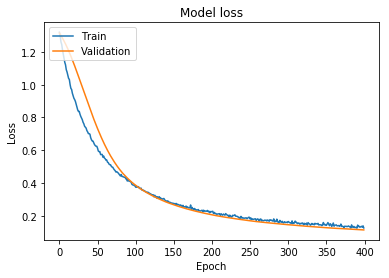

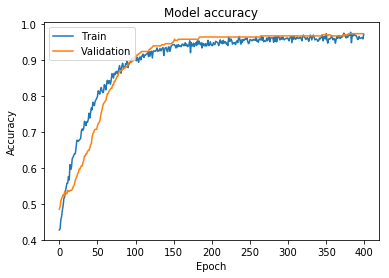

In [37]:
def plot(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Plot training & validation accuracy values
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
plot(history)

In [38]:
display(Markdown('#### Everything looks good. Lets see what sort of accuracy we get on the testing set '))

loss, acc = model.evaluate(testing_x.reshape(-1, data_x_scaled.shape[1], 1), testing_y)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

#### Everything looks good. Lets see what sort of accuracy we get on the testing set 

120/120 [==============================] - 0s 32us/step

Testing loss: 0.10194108858704568, acc: 0.9833333333333333



## Further steps and investigations

From the analysis above, its clear that the network had some trouble picking up on the patterns as can be seen by the very high number of epochs needed to get a good result. Still we were able to achieve > 98% accuracy from our testing set which implies a strong correlation between the signals collected and the image displayed on the video. 

Some next steps are outlined below. 

* Gather more data. This will give us a better gauge of the effectiveness of the model. 
* Look at the failed cases in more detail and see if we can spot the issues there.
* We could increase the number of images from 4 to a grid of 32 in checkerboard pattern with various boxes turned black or white. This would enable us to start gauging the fidelity of data collected.
* Drop the monitor resolution really low to 320x200 and then display random noise and collect the signal. Try and train the model and see if we can truly 'see' what the monitor is displaying purely from the leaky signals. 